# Телеком — задача проекта
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг
Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных
Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План работы
 - Загрузить все предоставленные данные
 - При нобходимости, выполнить предобработку данных
 - Провести исследовательский анализ данных
 - Объединить все датасеты в один
 - Создать целевой признак
 - Выбрать несколько типов модели для выполнения задачи
 - Подготовить признаки для каждого типа модели
 - Разбить выборку на обучающую и тестовую
 - Обучить модели и выбрать лучшую на кросс-валидации по метрике AUC-ROC
 - Проверить выбранную модель на тестовой выборке
 - Написать общий вывод

## Загрузка и осмотр данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [2]:
warnings.filterwarnings("ignore")

In [3]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
except:
    contract = pd.read_csv('contract.csv')

In [4]:
try:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
except:
    personal = pd.read_csv('personal.csv')

In [5]:
try:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
except:
    internet = pd.read_csv('internet.csv')

In [6]:
try:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    phone = pd.read_csv('phone.csv')

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Столбец EndDate содержит даты только для ушедших клиентов, он послужит для выделения целевого признака.  
TotalCharges имеет тип данных 'object', возможно некоторым клиентам просто не успели выставить счёт в момент выгрузки данных.

In [9]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [10]:
contract.duplicated().sum()

0

<AxesSubplot:>

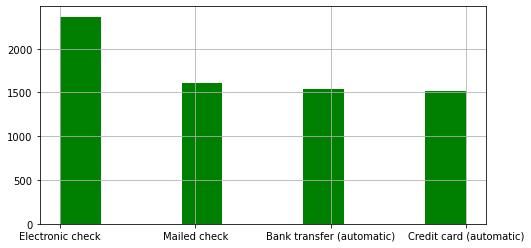

In [11]:
contract['PaymentMethod'].hist(color='green', figsize=(8, 4))

Среди методов оплаты выделяется Electronic check, остальные три примерно на одном уровне.

<AxesSubplot:>

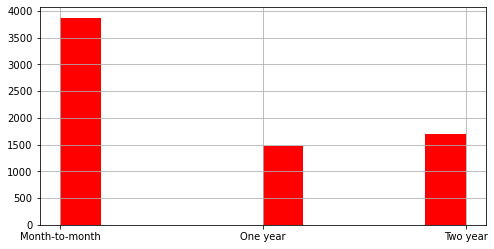

In [12]:
contract['Type'].hist(color='red', figsize=(8, 4))

Большинство контрактов заключаются помесячно.

In [13]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [14]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [15]:
personal['gender'].value_counts(normalize='True')

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

Количество мужчин и женщин в выборке практически равно.

In [16]:
personal['SeniorCitizen'].value_counts(normalize='True')

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

Пожилых клиентов в разы меньше чем остальных.

In [17]:
personal['Partner'].value_counts(normalize='True')

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

Почти половина клиентов состоит в браке.

In [18]:
personal['Dependents'].value_counts(normalize='True')

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

70% клиентов не имеют иждивенцев.

In [19]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [20]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [21]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [22]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Количество строк в датасетах с информацией по услугам телефонии и интернет-услугах меньше общего числа пользователей.  
Не все клиенты пользуются обоими видами услуг.

Дополнительных вопросов по работе нет.

## Объединение датасетов и осмотр признаков

In [23]:
df = pd.merge(personal, contract, on='customerID', how='outer')
df = pd.merge(df, phone, on='customerID', how='outer')
df = pd.merge(df, internet, on='customerID', how='outer')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [25]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


In [26]:
df.columns = df.columns.str.lower()

In [27]:
df = df.rename(columns={'customerid': 'customer_id', 'seniorcitizen': 'senior_citizen', 'begindate': 'begin_date', 'enddate': 'end_date', 'paperlessbilling': 'paperless_billing',
                        'paymentmethod': 'payment_method', 'monthlycharges':'monthly_charges', 'totalcharges': 'total_charges', 'multiplelines': 'multiple_lines',
                        'internetservice': 'internet_service', 'onlinesecurity': 'online_security', 'onlinebackup': 'online_backup', 'deviceprotection': 'device_protection',
                        'techsupport': 'tech_support', 'streamingtv': 'streaming_tv', 'streamingmovies': 'streaming_movies'})

В столбце 'total_charges' есть пропущенные значения.

In [28]:
df.query('total_charges==" "')

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
488,4472-LVYGI,Female,0,Yes,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,NaN,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,Male,0,No,Yes,2020-02-01,No,Two year,No,Mailed check,20.25,,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.75,,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,19.85,,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.35,,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,20.00,,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,2020-02-01,No,One year,Yes,Mailed check,19.70,,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,73.35,,Yes,DSL,No,Yes,Yes,Yes,Yes,No


Это данные клиентов заключивших договор в день выгрузки датасета, эти данные нам ничем не помогут, их стоит отбросить.

In [29]:
df = df.loc[df['total_charges'] != ' ']

In [30]:
df['total_charges'] = df['total_charges'].astype('float64')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   gender             7032 non-null   object 
 2   senior_citizen     7032 non-null   int64  
 3   partner            7032 non-null   object 
 4   dependents         7032 non-null   object 
 5   begin_date         7032 non-null   object 
 6   end_date           7032 non-null   object 
 7   type               7032 non-null   object 
 8   paperless_billing  7032 non-null   object 
 9   payment_method     7032 non-null   object 
 10  monthly_charges    7032 non-null   float64
 11  total_charges      7032 non-null   float64
 12  multiple_lines     6352 non-null   object 
 13  internet_service   5512 non-null   object 
 14  online_security    5512 non-null   object 
 15  online_backup      5512 non-null   object 
 16  device_protection  5512 

Создадим целевой признак при помощи столбца 'end_date':

In [32]:
def exit(row):
    if row['end_date'] == "No":
        return 0
    else:
        return 1

In [33]:
df['exited'] = df.apply(exit, axis=1)

In [34]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,exited
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,29.85,NaN,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,...,1889.50,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,...,108.15,No,DSL,Yes,Yes,No,No,No,No,1
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),...,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,151.65,No,Fiber optic,No,No,No,No,No,No,1


При помощи двух столбцов с датами, создадим новый признак с суммарной длительностью контракта в днях.

In [35]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y.%m.%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y.%m.%d')

In [36]:
df['span'] = ((df['end_date'] - df['begin_date'])/np.timedelta64(1, 'D')).astype('float64')

Теперь взглянем на влияние отдельных признаков на уход клиентов.

<AxesSubplot:xlabel='exited', ylabel='monthly_charges'>

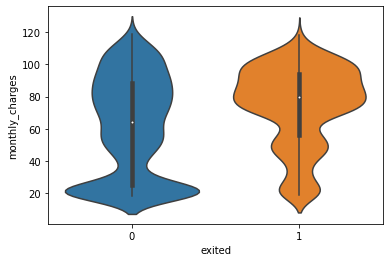

In [37]:
sns.violinplot(x='exited', y='monthly_charges', data=df)

Ушедшие клиенты платили большие суммы в месяц.

<AxesSubplot:xlabel='exited', ylabel='span'>

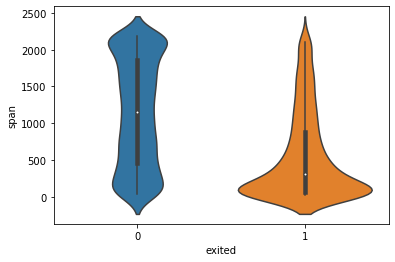

In [38]:
sns.violinplot(x='exited', y='span', data=df)

Значительная доля ушедших клиентов пробыли с компанией меньше года.

<AxesSubplot:xlabel='payment_method', ylabel='count'>

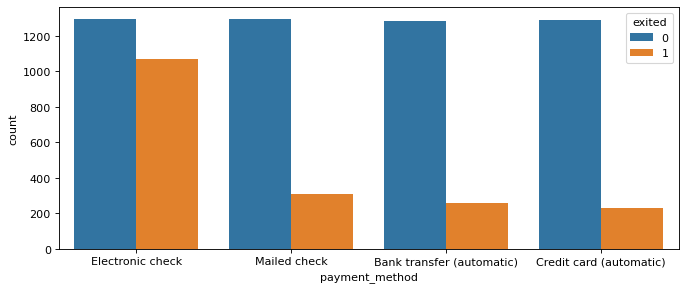

In [39]:
plt.figure(figsize=(10, 4), dpi= 80)
sns.countplot(x='payment_method', hue='exited', data=df)

Большинство ушедших оплачивали услуги электронным чеком.

<AxesSubplot:xlabel='internet_service', ylabel='count'>

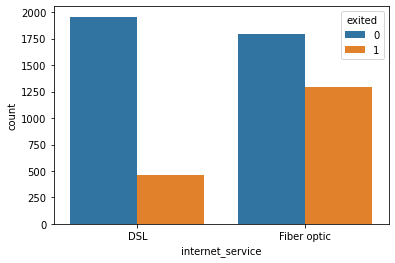

In [40]:
sns.countplot(x='internet_service', hue='exited', data=df)

Подключенные к интернету через Fiber optic уходили чаще чем клиенты с DSL.

Заполним пропуски в столбцах с дополнительными услугами значением 'No service'.

In [41]:
df = df.fillna('No service')

Теперь рассмотрим как признаки коррелируют между собой.

In [42]:
df = df.set_index('customer_id')

In [43]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['senior_citizen', 'monthly_charges', 'total_charges', 'exited', 'span']


,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,exited,span
gender,1.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
senior_citizen,0.00,1.00,0.02,0.32,0.05,0.12,0.09,0.24,0.29,0.30,...,0.09,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.23,0.03
partner,0.00,0.02,1.00,0.65,0.49,0.12,0.18,0.01,0.24,0.20,...,0.09,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.23,0.49
dependents,0.00,0.32,0.65,1.00,0.20,0.13,0.15,0.17,0.22,0.18,...,0.01,0.11,0.12,0.10,0.09,0.11,0.09,0.08,0.25,0.21
begin_date,0.02,0.05,0.49,0.20,1.00,0.59,0.77,0.08,0.47,0.42,...,0.47,0.19,0.46,0.50,0.50,0.45,0.42,0.43,0.51,1.00
end_date,0.00,0.12,0.12,0.13,0.59,1.00,0.36,0.16,0.21,0.32,...,0.04,0.29,0.31,0.26,0.25,0.30,0.21,0.21,1.00,0.41
type,0.00,0.09,0.18,0.15,0.77,0.36,1.00,0.11,0.28,0.39,...,0.24,0.50,0.64,0.58,0.63,0.67,0.55,0.55,0.25,0.67
paperless_billing,0.00,0.24,0.01,0.17,0.08,0.16,0.11,1.00,0.37,0.47,...,0.10,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.30,0.00
payment_method,0.00,0.29,0.24,0.22,0.47,0.21,0.28,0.37,1.00,0.40,...,0.17,0.32,0.31,0.29,0.30,0.32,0.28,0.28,0.45,0.37
monthly_charges,0.01,0.30,0.20,0.18,0.42,0.32,0.39,0.47,0.40,1.00,...,0.71,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.36,0.41


In [44]:
interval_cols = ['senior_citizen', 'monthly_charges', 'total_charges', 'exited', 'span']
phik_overview = df.phik_matrix(interval_cols = interval_cols)

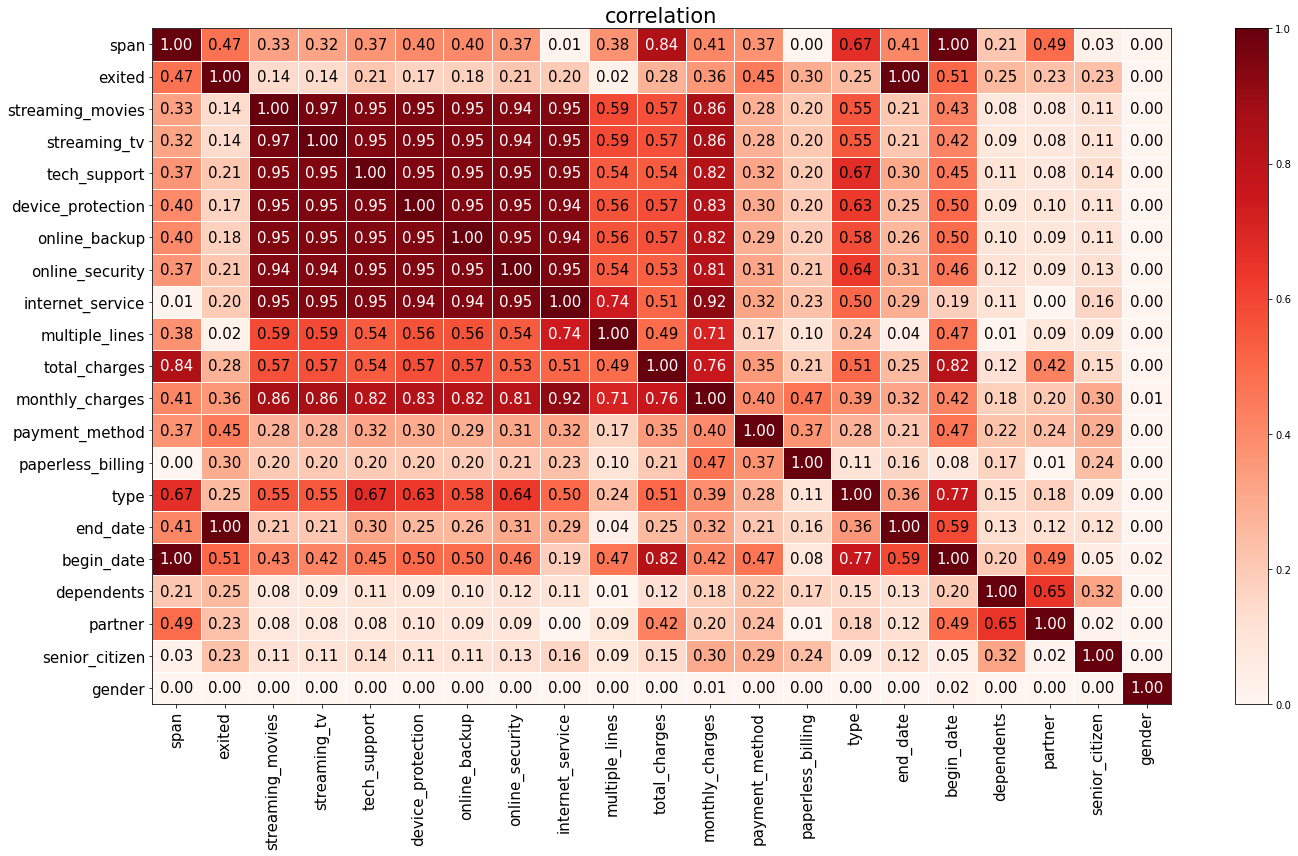

In [45]:
plot_correlation_matrix(phik_overview.values, 
                       x_labels = phik_overview.columns,
                       y_labels = phik_overview.index,
                       vmin = 0,
                       vmax = 1,
                       color_map= "Reds",
                       fontsize_factor = 1.5,
                       figsize = (20, 12))
plt.show();

Дополнительные интернет-услуги сильно связяны между собой, возможно они предоставляются преимущественно в пакетах.  
Общее сумма платежей сильно привязана к дате начала контракта, всё логично.  
Также с датой и длительностью коррелирует тип контракта.  
Наличие партнера и иждивенцев предсказуемо связаны.  
Пол в данном случае не влияет ни на что.

Создадим признак с общим числом дополнительных продуктов для каждого клиента.

In [46]:
def products(row):
    counter = 0
    if row['multiple_lines'] == 'Yes':
        counter += 1
    if row['online_security'] == 'Yes':
        counter += 1
    if row['online_backup'] == 'Yes':
        counter += 1
    if row['device_protection'] == 'Yes':
        counter += 1
    if row['tech_support'] == 'Yes':
        counter += 1
    if row['streaming_tv'] == 'Yes':
        counter += 1
    if row['streaming_movies'] == 'Yes':
        counter += 1
    return counter

In [47]:
df['total_products'] = df.apply(products, axis=1).astype('float64')

In [48]:
df.head()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,exited,span,total_products
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,...,DSL,No,Yes,No,No,No,No,0,31.0,1.0
5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,...,DSL,Yes,No,Yes,No,No,No,0,1036.0,2.0
3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,...,DSL,Yes,Yes,No,No,No,No,1,61.0,2.0
7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,...,DSL,Yes,No,Yes,Yes,No,No,0,1371.0,3.0
9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,...,Fiber optic,No,No,No,No,No,No,1,61.0,0.0


Удалим ненужные признаки, даты заменили количеством дней, пол ни на что не влияет, а total_charges можно восстановить через сумму платежа в месяц и длительность контракта.

In [49]:
df = df.drop(['begin_date', 'end_date', 'gender', 'total_charges'], axis=1)

Разделим признаки на категориальные и количественные.

In [50]:
cat_list = []
num_list = []

In [51]:
for i in df.columns:
    if df[i].dtype != 'float64':
        cat_list.append(i)
    elif df[i].dtype == 'float64':
        num_list.append(i)
display(cat_list, num_list)

['senior_citizen',
 'partner',
 'dependents',
 'type',
 'paperless_billing',
 'payment_method',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'exited']

['monthly_charges', 'span', 'total_products']

In [52]:
df.head()

,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,exited,span,total_products
customer_id,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,No service,DSL,No,Yes,No,No,No,No,0,31.0,1.0
5575-GNVDE,0,No,No,One year,No,Mailed check,56.95,No,DSL,Yes,No,Yes,No,No,No,0,1036.0,2.0
3668-QPYBK,0,No,No,Month-to-month,Yes,Mailed check,53.85,No,DSL,Yes,Yes,No,No,No,No,1,61.0,2.0
7795-CFOCW,0,No,No,One year,No,Bank transfer (automatic),42.30,No service,DSL,Yes,No,Yes,Yes,No,No,0,1371.0,3.0
9237-HQITU,0,No,No,Month-to-month,Yes,Electronic check,70.70,No,Fiber optic,No,No,No,No,No,No,1,61.0,0.0


## Построение моделей

Разделим выборки на обучающую и тестовую в соотношении 3 к 1.

In [53]:
features = df.drop('exited', axis=1)
target = df['exited']

In [54]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, stratify=target, random_state=261222)
features_train.shape, features_test.shape

((5274, 17), (1758, 17))

Перед кодированием создадим копии выборок для одной из моделей, которая работает лучше на незакодированных признаках.

In [56]:
features_train_cb = features_train.copy()
features_test_cb = features_test.copy()

Уберем целевой признак из списка на кодирование.

In [55]:
cat_list.remove('exited')

Кодируем категориальные признаки методом One Hot Encoding.

In [57]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[cat_list])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [58]:
features_train[encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[cat_list])

In [59]:
features_train = features_train.drop(cat_list, axis=1)

Масштабируем количественные признаки.

In [60]:
scaler = StandardScaler()

In [61]:
features_train[num_list] = scaler.fit_transform(features_train[num_list])

In [62]:
features_train.head()

,monthly_charges,span,total_products,senior_citizen_1,partner_Yes,dependents_Yes,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),...,online_backup_No service,online_backup_Yes,device_protection_No service,device_protection_Yes,tech_support_No service,tech_support_Yes,streaming_tv_No service,streaming_tv_Yes,streaming_movies_No service,streaming_movies_Yes
customer_id,,,,,,,,,,,,,,,,,,,,,
6810-VCAEX,-0.836790,0.591466,0.266840,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5989-PGKJB,0.711832,-0.669807,-0.223513,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4719-UMSIY,-1.501435,-1.075979,-1.204220,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3785-KTYSH,-1.336935,0.834635,-0.713867,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8039-EQPIM,-0.152206,1.486648,1.247547,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [63]:
features_test[encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[cat_list])
features_test = features_test.drop(cat_list, axis=1)

In [64]:
features_test[num_list] = scaler.transform(features_test[num_list])

In [65]:
features_test.head()

,monthly_charges,span,total_products,senior_citizen_1,partner_Yes,dependents_Yes,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),...,online_backup_No service,online_backup_Yes,device_protection_No service,device_protection_Yes,tech_support_No service,tech_support_Yes,streaming_tv_No service,streaming_tv_Yes,streaming_movies_No service,streaming_movies_Yes
customer_id,,,,,,,,,,,,,,,,,,,,,
4530-NDRKU,-1.521374,0.387043,-1.204220,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7716-YTYHG,0.572257,0.630212,-0.223513,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3930-ZGWVE,-1.498112,-1.280402,-1.204220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4795-WRNVT,0.008970,0.305542,0.266840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9912-GVSEQ,0.964397,-0.264970,0.757193,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Для каждой модели подберем оптимальные параметры с помощью GridSearchCV.  
Начнем с линейной модели RidgeClassifier.

In [66]:
model = RidgeClassifier(random_state=261222)
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1],
              'class_weight' :['balanced', None],
              'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
GSCV = GridSearchCV(model, param_grid, cv=4, scoring='roc_auc')
GSCV.fit(features_train, target_train)
GSCV.best_score_

0.8466652097902096

Теперь попробуем дерево решений.

In [67]:
model = DecisionTreeClassifier(random_state=261222)
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_split': [1, 2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'class_weight': ['balanced', None]}
GSCV = GridSearchCV(model, param_grid, cv=4, scoring='roc_auc')
GSCV.fit(features_train, target_train)
GSCV.best_score_

0.8491760827556281

И CatBoostClassifier.

In [68]:
%%time
model = CatBoostClassifier(eval_metric='AUC', loss_function='Logloss', cat_features=cat_list, auto_class_weights='Balanced', verbose=False, random_state=261222)
param_grid = {'learning_rate': [0.03, 0.1],
              'max_depth': [2, 3, 4, 5],
              'l2_leaf_reg': [1, 3]}
GSCV = GridSearchCV(model, param_grid, cv=4, scoring='roc_auc')
GSCV.fit(features_train_cb, target_train)
GSCV.best_score_

Wall time: 40min 58s


0.9198883954849864

In [69]:
GSCV.best_params_

{'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 3}

Лучший результат показала Catboost, осталось проверить её на тестовой выборке.

In [70]:
model = GSCV.best_estimator_
display('roc_auc', roc_auc_score(target_test, model.predict_proba(features_test_cb)[:, 1]))
display('accuracy', accuracy_score(target_test, model.predict(features_test_cb)))

'roc_auc'

0.9193386266642561

'accuracy'

0.8424345847554039

ROC-AUC больше 0.91 соответствует целевому значению.  
Accuracy 0.84 показывает, что модель даст правильное предсказание примерно по 84 из 100 пользователей.

Осталось посмотреть какие признаки оказались наиболее важными для модели.

In [71]:
feature_importance = pd.DataFrame(data = {'feature': features_train_cb.columns, 'percent': model.feature_importances_})
feature_importance.sort_values('percent', ascending=False).reset_index(drop=True)

,feature,percent
0,span,71.296107
1,type,8.215837
2,monthly_charges,7.135481
3,internet_service,2.572617
4,payment_method,1.811255
5,multiple_lines,1.392762
6,online_security,1.163961
7,total_products,1.093175
8,tech_support,1.056424
9,online_backup,0.968718


Длительность нахождения клиента в компании лидирует с огромным отрывом, также довольно важны тип договора и месячная сумма платежа.

## Общий вывод

Предоставленные данные в целом пригодны для работы.  
Целевой признак и признак ставший основным для определения оттока были созданы из предоставленных данных с датами начала и конца договора.  
По результатам анализа, несколько бесполезных признаков были отброшены.  
Лучший результат показала модель Catboost c параметрами:
'iterations': 1000,
 'l2_leaf_reg': 1,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'max_depth': 3

# Отчёт

В рамках проекта были выполнены все пункты плана работы.  
Можно выделить основные этапы выполнения проекта:
- Загрузка и предобработка данных;
- Исследовательский анализ;
- Подготовка признаков;
- Обучение моделей;
- Тестирование лучшей модели.  

Во время предобработки часть данных была приведена к неоходимому формату, в частности даты начала и окончания контракта, а также суммы платежей.  
Часть данных отсутствовала, что мешало привести их к необходимому формату. Это удалось преодолеть отбросив данные клиентов подписавших договор в день выгрузки, а также заменой значения 'No' на дату выгрузки в столбце с датой окончания договора.  
Целевой признак был выведен на основе данных с датами ухода клиента из компании.  
Датафреймы были объединены в один с использованием уникального идентификатора пользователя в качестве индекса.  
По результатам исследовательского анализа, незначительная часть данных была удалена, поскольку не несла никакой пользы для исследования.  
Для обучения были выбраны следующие типы моделей:
- линейная модель RidgeClassifier;
- дерево решений DecisionTreeClassifier;
- градиентный бустинг CatBoostClassifier.  

Признаки были разбиты на обучающую и тестовую выборки в соотношении 3 к 1, валидационная выборка не понадобилась, посколько при обучении и подборе параметров использовалась кросс-валидация.  
Для первых двух моделей категориальные признаки были закодированы методом One Hot Encoding(OHE), а количественные промасштабированы при помощи StandardScaler.  
Признаки для Catboost не требуют дополнительной обработки, поскольку модель имеет встроенные инструменты и показывает лучшие результаты с необработанными данными.  
Подбор параметров для Catboost можно уверенно назвать главной трудностью в выполнении проекта, поскольку с незакодированными признаками, обучение и кросс-валидация занимали по несколько часов, что сильно тормозило выполнение проекта. Проблема была решена уменьшением количества параметров при использовании GridSearchCV.
По условиям задачи, оценочной метрикой обучения моделей является ROC-AUC, ниже приведены данные с лучшими результами по итогам кросс-валидации:

In [5]:
pd.DataFrame({'Модель':['RidgeClassifier', 'DecisionTreeClassifier', 'CatBoostClassifier'], 'AUC-ROC':[0.8466652097902096, 0.8491760827556281, 0.9193386266642561]})

,Модель,AUC-ROC
0,RidgeClassifier,0.846665
1,DecisionTreeClassifier,0.849176
2,CatBoostClassifier,0.919339


Лучший результат показал градиентный бустинг Catboost с параметрами: 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'loss_function': 'Logloss', 'max_depth': 3  
В итоговую модель вошли все признаки, кроме пола клиента, общей суммы платежей и дат подписания и разрыва договора.  
Наиболее значимой для модели оказалась длительность нахождения клиента в компании, также довольно важными были тип договора, сумма ежемясячного платежа и тип интернет-соединения.  
По результатам тестирования, модель показала результат AUC-ROC в 0.9193386266642561 и Accuracy в 0.8424345847554039.  
В заключение были сделаны краткие выводы по итогам выполненной работы.